### Calculate integrated APAR from satellite extraction and connect to ground data
Uses smoothed NDVI time series from LMF and HLS satellite data extracted at CPER plot scale.
Calculates fPAR, then APAR using NEON PAR readings. Calculated integrated APAR by summing 
APAR from the start of season (calculated separately from the NDVI time series) up until the 
date of clipping for production.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
# keep block and ecosite
# what happened to new heavy
# erika is sorting out 2022 biomass

#### Input/Output paths

In [18]:
ndvi_path =  "./data/carm3_ndvi_2014_2023_cln.csv" 
sos_path = "./data/carm3_sos_2014_2023.csv"
par_path = "../../data/sensors/par/neon_d10_cper_par_cln.csv"

In [19]:
outPATH = "./data/carm3_biomass_iapar_2014_2023.csv"

#### Helper functions

In [20]:
def ndvi_to_fpar(ndvi_ts):
    SR = (1 + ndvi_ts) / (1 - ndvi_ts)
    # SR_min = 1.55  # this is based on Grigera et al., 2007
    SR_min = 1.11  # this is based on an NDVI of 0.05
    SR_max = 11.62
    fPAR = SR / (SR_max - SR_min) - SR_min / (SR_max - SR_min)
    return fPAR

def calc_apar_baseline(apar, sos):
    apar_baseline = np.median(apar.iloc[:sos])
    return apar_baseline

def remove_apar_sos(apar, sos):
    apar_mod = apar.copy()
    apar_mod.iloc[:sos] = np.nan
    return apar_mod

In [29]:
ndvi = pd.read_csv(ndvi_path, parse_dates=[0])
par = pd.read_csv(par_path, parse_dates=[0])
sos = pd.read_csv(sos_path, parse_dates=[3])

In [30]:
# calculate fPAR from NDVI
ndvi['fPAR'] = ndvi_to_fpar(ndvi['NDVI_smooth_avg'])

# get year from date in PAR and sampling data
par['Year'] = par['Date'].dt.year

In [31]:
par['Year'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

#### Biomass calculations

In [32]:
#rename StartDateTime column from par to Date and PAR_MJ_m2_day to PAR
par = par.rename(columns={"startDateTime": "Date", "PAR_MJ_m2_day": "PAR"})

# create new dataframe that is a subset of columns needed from ndvi dataframe
APAR = ndvi[['Date', 'Id', 'fPAR','NDVI_smooth_avg','Year']]

#take only date and PAR columns from PAR
par = par[['Date', 'PAR']]
APAR = pd.merge(APAR, par, on='Date')

#sort by Id, Date
APAR = APAR.sort_values(by=['Id', 'Date'])
#add APAR column, which is fPAR * PAR
APAR['APAR'] = APAR['fPAR'] * APAR['PAR']
#Add year column
APAR['Year'] = pd.DatetimeIndex(APAR['Date']).year

In [24]:
# calculate baseline APAR based on SOS
APAR_baseline = APAR.groupby(['Year', 'Id']).apply(
    lambda x: calc_apar_baseline(x['APAR'], sos['SOS_doy'][(sos['Year'] == x.name[0]) &
                                        (sos['Id'] == x.name[1])].values[0]))
APAR_baseline.name = 'APAR_baseline'
APAR_baseline = APAR_baseline.reset_index()

In [25]:
APAR = pd.merge(APAR, APAR_baseline, on=['Id', 'Year'])

In [26]:
#Add new column that is APAR - Baseline_APAR
APAR['APAR_adjusted'] = APAR['APAR'] - APAR['APAR_baseline']
#convert adjusted APAR that are negative to 0

APAR['APAR_adjusted'] = np.where(APAR['APAR_adjusted'] < 0, 0, APAR['APAR_adjusted'])
#iAPAR calculation

# create a new column that has APAR values starting from SOS and NaNs before this date
APAR['APAR_modified'] = APAR.groupby(['Year', 'Id'])['APAR_adjusted'].transform(
    lambda x: remove_apar_sos(x, sos['SOS_doy'][(sos['Year'] == x.name[0]) &
                                        (sos['Id'] == x.name[1])].values[0]))

# calculate the cumulative sum per year and store it in the 'iAPAR' column
APAR['iAPAR'] = APAR.sort_values(['Id', 'Year', 'Date']).groupby(['Id', 'Year'])['APAR_modified'].cumsum()

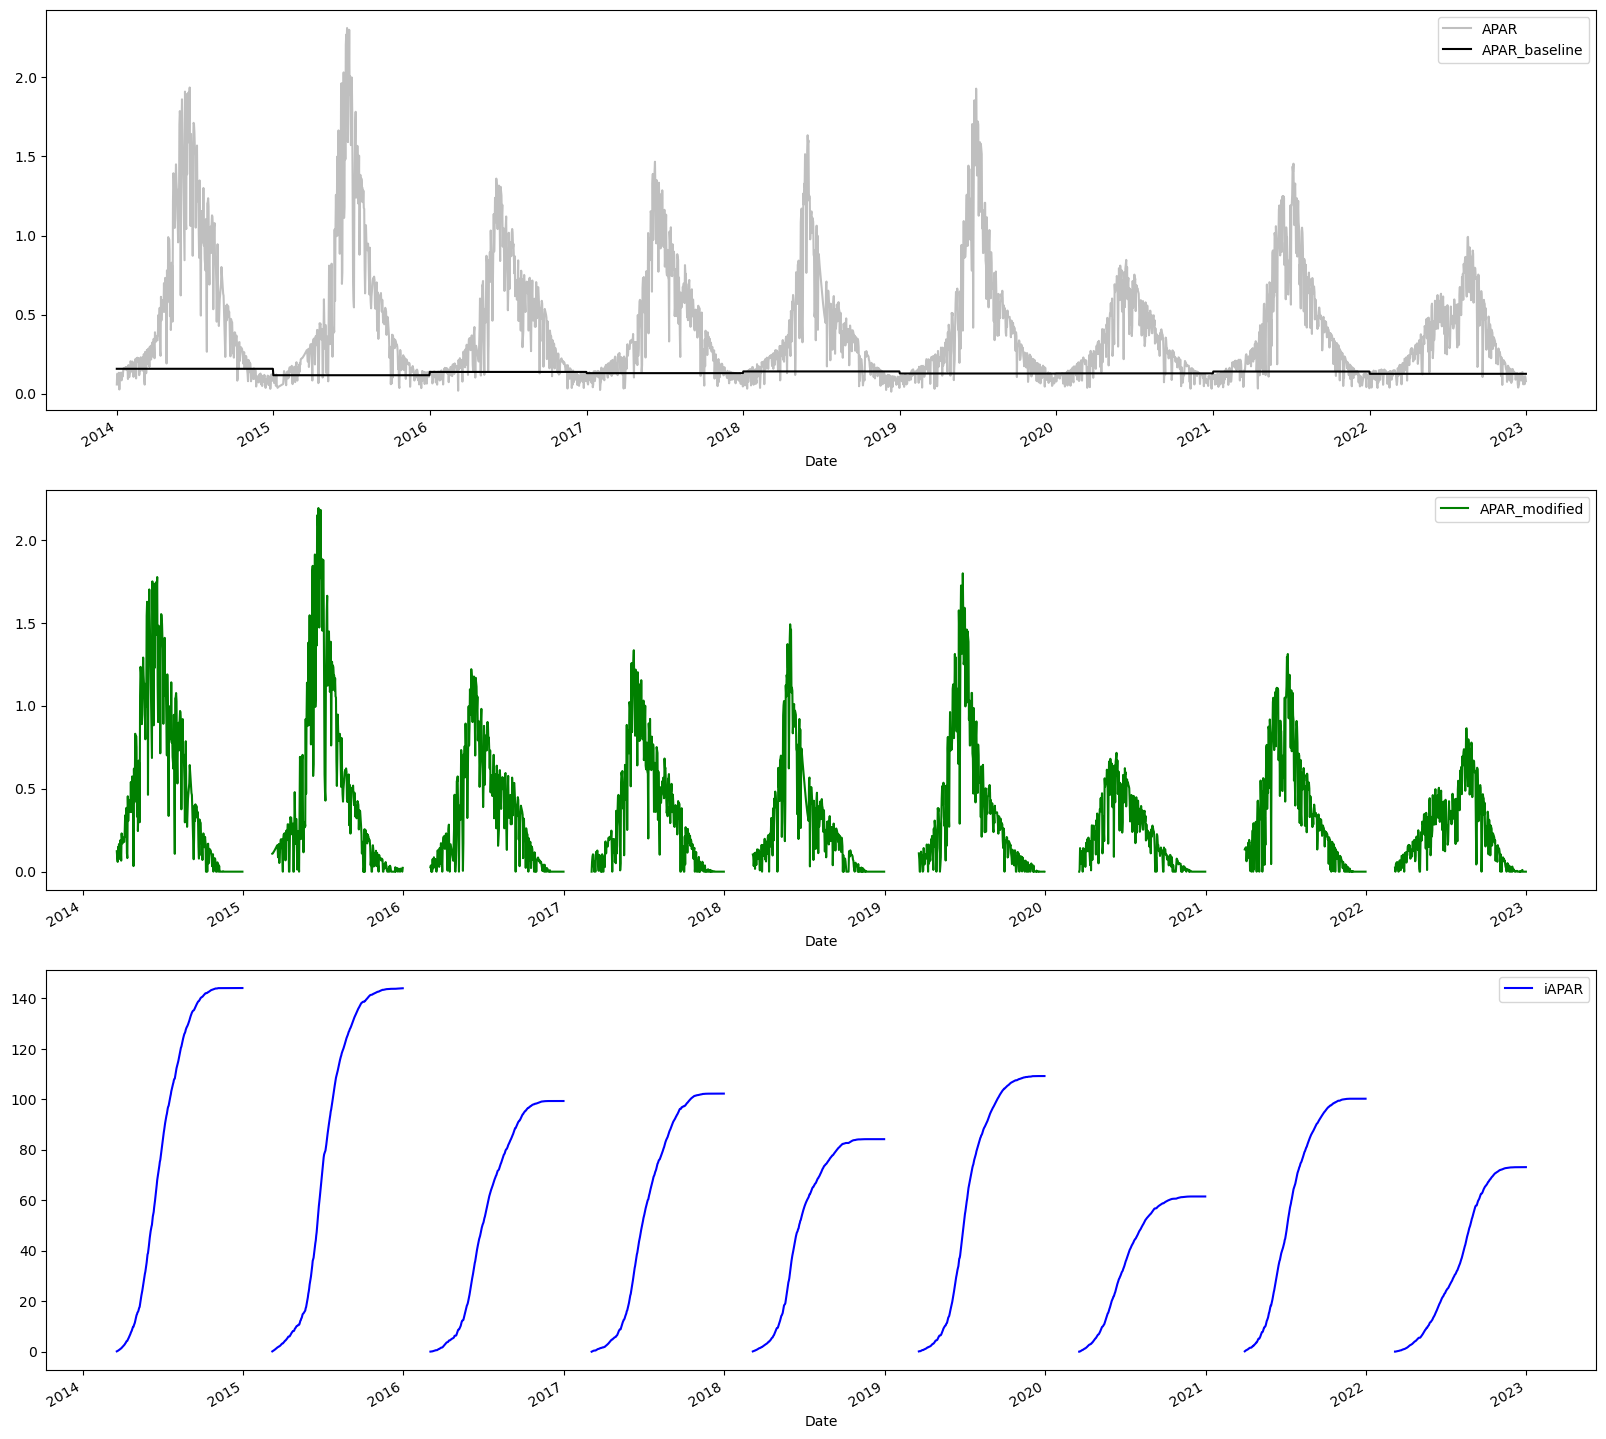

In [27]:
import seaborn as sns
fig, axs = plt.subplots(nrows=3, figsize=(20, 20))
plot = 'Northeast'
APAR[APAR['Id'] == plot].plot(x='Date', y='APAR', ax=axs[0], c='grey', alpha=0.5)
APAR[APAR['Id'] == plot].plot(x='Date', y='APAR_baseline', ax=axs[0], c='black')
APAR[APAR['Id'] == plot].plot(x='Date', y='APAR_modified', ax=axs[1], c='green')
APAR[APAR['Id'] == plot].plot(x='Date', y='iAPAR', ax=axs[2], c='blue')
plt.show()

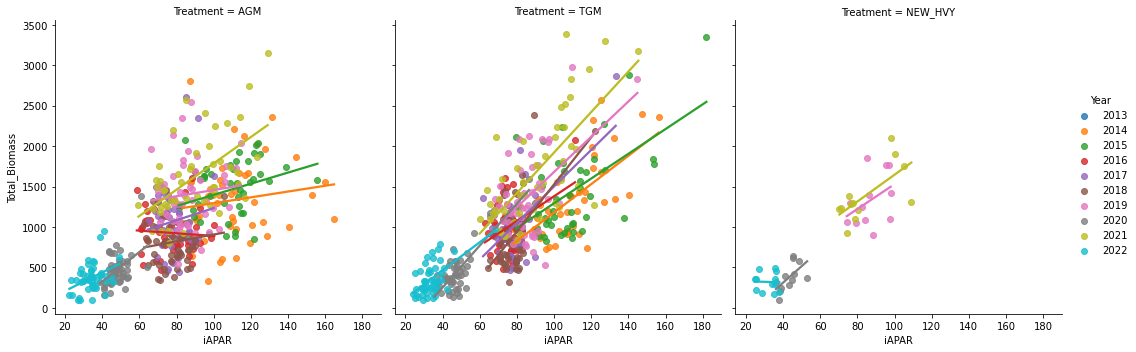

In [23]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Year', col='Treatment', ci=None, 
           data=df_merged.reset_index())
plt.show()

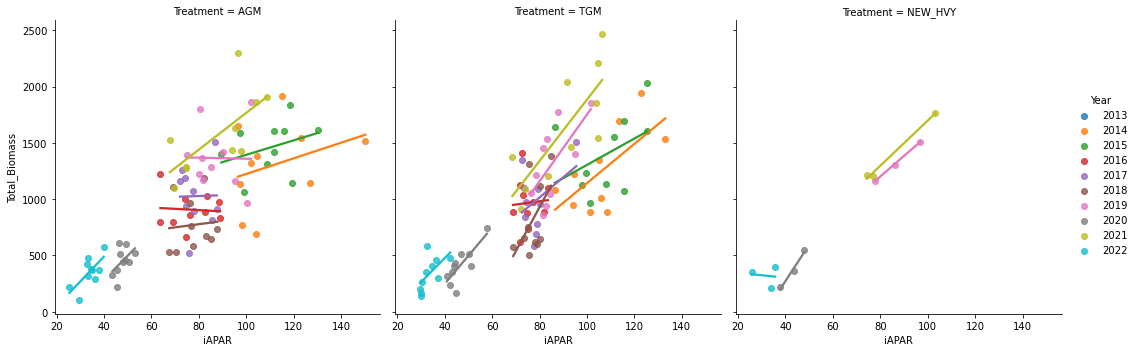

In [24]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Year', col='Treatment', ci=None, 
           data=df_merged.groupby(['Year', 'Treatment', 'Pasture']).mean(numeric_only=True).reset_index())
plt.show()

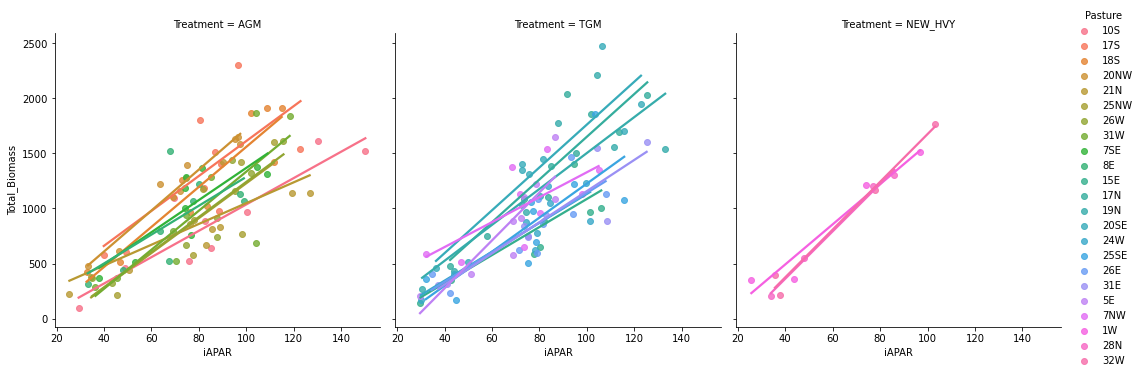

In [25]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Pasture', col='Treatment', ci=None, 
           data=df_merged.groupby(['Year', 'Treatment', 'Pasture']).mean(numeric_only=True).reset_index())
plt.show()

<Figure size 432x288 with 0 Axes>

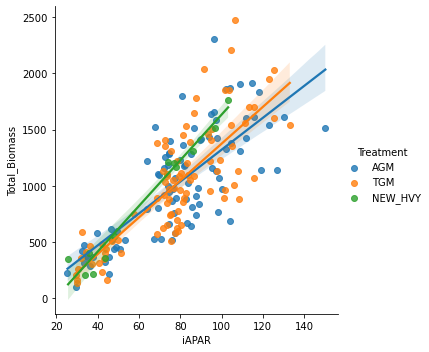

In [26]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Treatment', ci=95, 
           data=df_merged.groupby(['Year', 'Pasture', 'Treatment']).mean(numeric_only=True).reset_index())
plt.show()

In [27]:
df_merged.to_csv(outPATH, index=False)